# 3_scann — ScaNN (partitioning + anisotropic PQ) и оценка Recall@K

Этот ноутбук построен по тому же шаблону, что и `2_lorann.ipynb`:

1) Загружает общие датасет-артефакты, созданные `0_data.ipynb` (base / queries / gt_test) из `./artifacts/data`.
2) Обучает ScaNN-подобный индекс (coarse partitioning + anisotropic PQ/LUT + точный rerank).
3) Сохраняет результаты поиска (run-файл) в `./artifacts/runs/scann/ds<DATASET_ID>/...`.
4) Агрегирует все сохранённые прогоны и строит **единые графики Recall@10 для размерностей 50/100/200/300**.

Примечание: реализация `methods/scann.py` — учебная (NumPy), но сохраняет линейно-алгебраическую структуру ScaNN
(разбиение на кластеры, PQ/LUT, score-aware/anisotropic обновление центроидов через решение СЛАУ).


In [12]:
import json
import time
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# Поиск корня репозитория
# ----------------------------
p = Path.cwd().resolve()
REPO_ROOT = None
for _ in range(8):
    if (p / "methods" / "scann.py").exists():
        REPO_ROOT = p
        break
    p = p.parent

if REPO_ROOT is None:
    raise FileNotFoundError("Не удалось найти корень репозитория (ожидался файл methods/scann.py в родителях).")

ARTIFACTS_DATA = (REPO_ROOT / "artifacts" / "data").resolve()
ARTIFACTS_RUNS = (REPO_ROOT / "artifacts" / "runs").resolve()
ARTIFACTS_RUNS.mkdir(parents=True, exist_ok=True)

print("REPO_ROOT:", REPO_ROOT)
print("ARTIFACTS_DATA:", ARTIFACTS_DATA)
print("ARTIFACTS_RUNS:", ARTIFACTS_RUNS)

# Чтобы импортировать methods/scann.py
import sys
import importlib

METHODS_DIR = (REPO_ROOT / "methods").resolve()
sys.path.insert(0, str(METHODS_DIR))

# В Jupyter модуль мог быть уже импортирован в старой версии (кэш sys.modules).
# Перезагружаем модуль, чтобы изменения в файле scann.py применились.
import scann as _scann_mod  # noqa: E402
_scann_mod = importlib.reload(_scann_mod)

ScannConfig = _scann_mod.ScannConfig
ScannIndex = _scann_mod.ScannIndex

print("METHODS_DIR:", METHODS_DIR)


REPO_ROOT: /home/ammo/Documents/AI-Masters/Вычислительная линейная алгебра/2025_2026/HW/Final_project/ann-nla-project
ARTIFACTS_DATA: /home/ammo/Documents/AI-Masters/Вычислительная линейная алгебра/2025_2026/HW/Final_project/ann-nla-project/artifacts/data
ARTIFACTS_RUNS: /home/ammo/Documents/AI-Masters/Вычислительная линейная алгебра/2025_2026/HW/Final_project/ann-nla-project/artifacts/runs
METHODS_DIR: /home/ammo/Documents/AI-Masters/Вычислительная линейная алгебра/2025_2026/HW/Final_project/ann-nla-project/methods


## 1) Fit + Search + Save run

Блок ниже:
- для каждой размерности `d in {50,100,200,300}` находит 3 файла (base / queries / gt_test) с одинаковым `dataset_id`;
- обучает индекс на `Xn` (unit-вектора);
- ищет `top_k` на `Q_test` с исключением self-match через `q_idx_test`;
- считает Recall@K и сохраняет run.

Если вы хотите прогонять только одну размерность — установите `RUN_DIMS = [300]`.


In [13]:
# ----------------------------
# Настройки эксперимента
# ----------------------------
DIMS = [50, 100, 200, 300]
RUN_DIMS = DIMS  # можно заменить на [300], если нужно быстрее

TOP_K = 10
EVAL_KS = [1, 10]  # для печати

# ScaNN-подобная конфигурация
cfg = ScannConfig(
    nlist=256,
    nprobe=8,

    n_subspaces=10,   # 10 удобно: делит 50/100/200/300, но в нашей реализации делимость не обязательна
    n_codewords=64,
    gamma=1.1,

    coarse_train_size=50_000,
    coarse_n_iters=20,

    pq_train_size=20_000,
    pq_n_iters=10,

    candidate_count=20000,
    reorder_k=2000,

    random_state=0,
)

# Идентификатор текущего "сета" параметров (пойдёт в имя run-файла)
RUN_TAG = f"nl{cfg.nlist}_np{cfg.nprobe}_M{cfg.n_subspaces}_Ks{cfg.n_codewords}_g{cfg.gamma}_cand{cfg.candidate_count}_rk{cfg.reorder_k}"
print("RUN_TAG:", RUN_TAG)

# ----------------------------
# Утилиты для загрузки артефактов с проверками
# ----------------------------
def _load_npz(path: Path) -> Dict[str, np.ndarray]:
    z = np.load(path, allow_pickle=False)
    return {k: z[k] for k in z.files}

def _get_dataset_id(z: Dict[str, np.ndarray]) -> str:
    if "dataset_id" not in z:
        raise KeyError(f"В файле нет поля dataset_id: {list(z.keys())}")
    return str(z["dataset_id"].tolist())

def _pick_one(paths: List[Path], what: str) -> Path:
    if len(paths) == 1:
        return paths[0]
    if len(paths) == 0:
        raise FileNotFoundError(f"Не найдено ни одного файла для: {what}")
    # Если вдруг несколько — берём самый свежий, но печатаем предупреждение.
    paths = sorted(paths, key=lambda p: p.stat().st_mtime, reverse=True)
    print(f"[WARN] Найдено несколько файлов для '{what}'. Беру самый новый: {paths[0].name}")
    return paths[0]

def resolve_dataset_paths(dim: int) -> Tuple[Path, Path, Path]:
    '''
    Найти base / queries / gt_test для заданной размерности.

    Ожидаем, что 0_data.ipynb генерирует имена, содержащие '__ds<DATASET_ID>'.
    '''
    dim = int(dim)

    # 1) queries — якорный файл, из него вытаскиваем ds-суффикс
    q_candidates = sorted(ARTIFACTS_DATA.glob(f"glove{dim}d_queries_*__ds*.npz"))
    if not q_candidates:
        q_candidates = sorted(ARTIFACTS_DATA.glob(f"glove{dim}d_queries_*.npz"))
    q_path = _pick_one(q_candidates, f"queries dim={dim}")

    if "__ds" not in q_path.name:
        raise RuntimeError(f"В имени queries-файла нет '__ds': {q_path.name}")

    ds_suffix = q_path.name.split("__ds")[-1].replace(".npz", "")

    # 2) base и gt_test должны иметь тот же ds_suffix
    base_candidates = sorted(ARTIFACTS_DATA.glob(f"glove{dim}d_base_*__ds{ds_suffix}.npz"))
    gt_candidates = sorted(ARTIFACTS_DATA.glob(f"glove{dim}d_gt_test_*__ds{ds_suffix}.npz"))

    base_path = _pick_one(base_candidates, f"base dim={dim}, ds={ds_suffix}")
    gt_path = _pick_one(gt_candidates, f"gt_test dim={dim}, ds={ds_suffix}")

    return base_path, q_path, gt_path

def recall_at_k(pred_ids: np.ndarray, gt_ids: np.ndarray, k: int) -> float:
    '''
    Recall@k = средняя доля попаданий предсказаний в GT-список (top-k).
    pred_ids: (nq, k')
    gt_ids: (nq, K_gt)
    '''
    k = int(k)
    pred = pred_ids[:, :k]
    gt = gt_ids[:, :k]
    hits = 0
    for i in range(pred.shape[0]):
        hits += np.intersect1d(pred[i], gt[i], assume_unique=False).size
    return float(hits) / float(pred.shape[0] * k)

# ----------------------------
# Основной цикл по размерностям
# ----------------------------
scann_runs_dir = (ARTIFACTS_RUNS / "scann").resolve()
scann_runs_dir.mkdir(parents=True, exist_ok=True)

for dim in RUN_DIMS:
    base_path, q_path, gt_path = resolve_dataset_paths(dim)

    base_z = _load_npz(base_path)
    queries_z = _load_npz(q_path)
    gt_z = _load_npz(gt_path)

    ds_base = _get_dataset_id(base_z)
    ds_q = _get_dataset_id(queries_z)
    ds_gt = _get_dataset_id(gt_z)

    if not (ds_base == ds_q == ds_gt):
        raise RuntimeError(f"dataset_id mismatch for dim={dim}: base={ds_base}, queries={ds_q}, gt={ds_gt}")

    # Строгая проверка совпадения q_idx_test (для сопоставимости)
    q_idx_test = queries_z["q_idx_test"].astype(np.int64, copy=False)
    if "q_idx_test" not in gt_z:
        raise KeyError("В gt_test нет q_idx_test — невозможно проверить сопоставимость.")
    if not np.array_equal(q_idx_test, gt_z["q_idx_test"].astype(np.int64, copy=False)):
        raise RuntimeError("q_idx_test mismatch между queries и gt_test. Артефакты несопоставимы.")

    Xn = base_z["Xn"].astype(np.float32, copy=False)        # (N, d), unit
    Q_test = queries_z["Q_test"].astype(np.float32, copy=False)
    gt_ids = gt_z["gt_ids"].astype(np.int32, copy=False)

    if gt_ids.shape[1] < TOP_K:
        raise RuntimeError(f"GT содержит только {gt_ids.shape[1]} соседей, нужно >= {TOP_K}.")

    print(f"\n[dim={dim}] DATASET_ID={ds_q}")
    print("Xn:", Xn.shape, "| Q_test:", Q_test.shape, "| GT:", gt_ids.shape)
    print("Files:", base_path.name, "|", q_path.name, "|", gt_path.name)

    # Fit
    index = ScannIndex(cfg)
    t0 = time.perf_counter()
    index.fit(Xn, assume_normalized=True)
    t1 = time.perf_counter()

    # Search
    t2 = time.perf_counter()
    pred_ids, pred_scores = index.search_batch(Q_test, top_k=TOP_K, exclude_ids=q_idx_test)
    t3 = time.perf_counter()

    # Метрики
    rec10 = recall_at_k(pred_ids, gt_ids, k=TOP_K)
    print(f"Recall@{TOP_K}: {rec10:.4f}")
    for kk in EVAL_KS:
        print(f"Recall@{kk}: {recall_at_k(pred_ids, gt_ids, k=kk):.4f}")

    fit_s = float(t1 - t0)
    search_s = float(t3 - t2)
    ms_per_q = 1000.0 * search_s / float(Q_test.shape[0])

    # Save run
    run_dir = (scann_runs_dir / f"ds{ds_q}").resolve()
    run_dir.mkdir(parents=True, exist_ok=True)

    run_path = (run_dir / f"scann_glove{dim}d_{RUN_TAG}.npz").resolve()

    meta = {
        "method": "scann_like",
        "dim": int(dim),
        "top_k": int(TOP_K),
        "recall@10": float(rec10),
        "fit_seconds": fit_s,
        "search_seconds": search_s,
        "ms_per_query": float(ms_per_q),
        "cfg": cfg.__dict__,
        "base_file": base_path.name,
        "queries_file": q_path.name,
        "gt_file": gt_path.name,
    }

    np.savez_compressed(
        run_path,
        dataset_id=np.array(ds_q, dtype=np.str_),
        pred_ids=pred_ids.astype(np.int32, copy=False),
        pred_scores=pred_scores.astype(np.float32, copy=False),
        meta=np.array(json.dumps(meta, ensure_ascii=False), dtype=np.str_),
    )

    print("Saved run:", run_path)


RUN_TAG: nl256_np8_M10_Ks64_g1.1_cand20000_rk2000

[dim=50] DATASET_ID=989456bc6cc2e6ed
Xn: (400000, 50) | Q_test: (20000, 50) | GT: (20000, 50)
Files: glove50d_base_N400000__ds989456bc6cc2e6ed.npz | glove50d_queries_N400000_nq100000_test20000_seed42__ds989456bc6cc2e6ed.npz | glove50d_gt_test_N400000_nq20000_k50_seed42__ds989456bc6cc2e6ed.npz
Recall@10: 0.8380
Recall@1: 0.8774
Recall@10: 0.8380
Saved run: /home/ammo/Documents/AI-Masters/Вычислительная линейная алгебра/2025_2026/HW/Final_project/ann-nla-project/artifacts/runs/scann/ds989456bc6cc2e6ed/scann_glove50d_nl256_np8_M10_Ks64_g1.1_cand20000_rk2000.npz

[dim=100] DATASET_ID=989456bc6cc2e6ed
Xn: (400000, 100) | Q_test: (20000, 100) | GT: (20000, 50)
Files: glove100d_base_N400000__ds989456bc6cc2e6ed.npz | glove100d_queries_N400000_nq100000_test20000_seed42__ds989456bc6cc2e6ed.npz | glove100d_gt_test_N400000_nq20000_k50_seed42__ds989456bc6cc2e6ed.npz
Recall@10: 0.8231
Recall@1: 0.8655
Recall@10: 0.8231
Saved run: /home/ammo/Document

## 2) 4_eval_runs — Агрегация ScaNN runs и единые графики по размерностям 50/100/200/300

Эта секция не обучает модели. Она:
- находит все run-файлы ScaNN в `artifacts/runs/scann/ds<DATASET_ID>/...`;
- загружает соответствующий GT для каждой размерности;
- пересчитывает Recall@10 (чтобы всё было консистентно);
- строит два графика:
  1) scatter всех прогонов по каждой размерности;
  2) bar chart лучшего Recall@10 для каждой размерности.


Found run files: 9
Aggregated runs: (9, 8)


,dataset_id,dim,run_file,recall@10,fit_seconds,search_seconds,ms_per_query,cfg
7,989456bc6cc2e6ed,50,scann_glove50d_nl256_np8_M10_Ks64_g1.1_cand200...,0.838005,2.100111,11.558967,0.577948,"{""nlist"": 256, ""nprobe"": 8, ""n_subspaces"": 10,..."
8,989456bc6cc2e6ed,50,scann_glove50d_nl256_np8_M10_Ks64_g1.1_cand200...,0.391695,2.150557,2.025994,0.101300,"{""nlist"": 256, ""nprobe"": 8, ""n_subspaces"": 10,..."
1,989456bc6cc2e6ed,100,scann_glove100d_nl256_np8_M10_Ks64_g1.1_cand20...,0.823100,2.602687,13.322109,0.666105,"{""nlist"": 256, ""nprobe"": 8, ""n_subspaces"": 10,..."
2,989456bc6cc2e6ed,100,scann_glove100d_nl256_np8_M10_Ks64_g1.1_cand20...,0.325085,2.640760,2.146994,0.107350,"{""nlist"": 256, ""nprobe"": 8, ""n_subspaces"": 10,..."
3,989456bc6cc2e6ed,200,scann_glove200d_nl256_np8_M10_Ks64_g1.1_cand20...,0.702840,2.522692,16.449032,0.822452,"{""nlist"": 256, ""nprobe"": 8, ""n_subspaces"": 10,..."
4,989456bc6cc2e6ed,200,scann_glove200d_nl256_np8_M10_Ks64_g1.1_cand20...,0.270355,2.507009,2.349092,0.117455,"{""nlist"": 256, ""nprobe"": 8, ""n_subspaces"": 10,..."
0,989456bc6cc2e6ed,300,20251221_165514__d300__k10__nlist1024__probe16...,0.633340,11.678865,40.456043,2.022802,{}
5,989456bc6cc2e6ed,300,scann_glove300d_nl256_np8_M10_Ks64_g1.1_cand20...,0.564660,2.738555,49.752964,2.487648,"{""nlist"": 256, ""nprobe"": 8, ""n_subspaces"": 10,..."
6,989456bc6cc2e6ed,300,scann_glove300d_nl256_np8_M10_Ks64_g1.1_cand20...,0.215450,2.820260,2.580054,0.129003,"{""nlist"": 256, ""nprobe"": 8, ""n_subspaces"": 10,..."


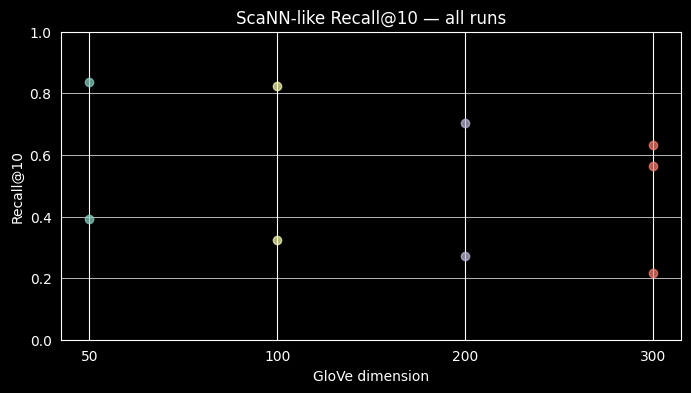

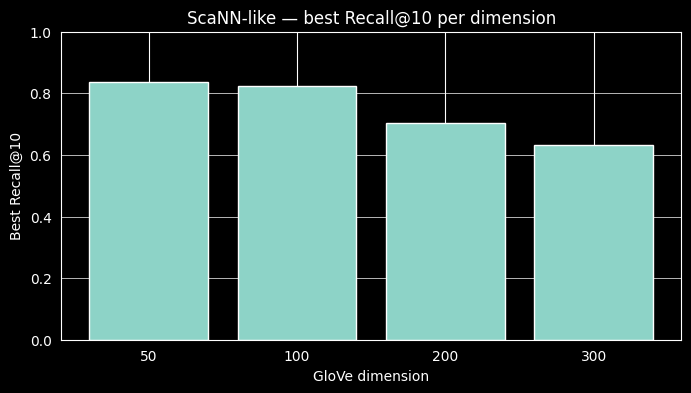

Saved: /home/ammo/Documents/AI-Masters/Вычислительная линейная алгебра/2025_2026/HW/Final_project/ann-nla-project/artifacts/runs/scann_eval_summary.csv


In [14]:
import json
import re
from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# Локальные утилиты (делаем ячейку самодостаточной, как в 2_lorann.ipynb)
# ----------------------------
def _load_npz(path: Path) -> Dict[str, np.ndarray]:
    z = np.load(path, allow_pickle=False)
    return {k: z[k] for k in z.files}

def _get_dataset_id(z: Dict[str, np.ndarray]) -> str:
    if "dataset_id" not in z:
        raise KeyError(f"В файле нет поля dataset_id: {list(z.keys())}")
    return str(z["dataset_id"].tolist())

def recall_at_k(pred_ids: np.ndarray, gt_ids: np.ndarray, k: int) -> float:
    '''
    Recall@k = средняя доля попаданий предсказаний в GT-список (top-k).
    pred_ids: (nq, k')
    gt_ids: (nq, K_gt)
    '''
    k = int(k)
    pred = pred_ids[:, :k]
    gt = gt_ids[:, :k]
    hits = 0
    for i in range(pred.shape[0]):
        hits += np.intersect1d(pred[i], gt[i], assume_unique=False).size
    return float(hits) / float(pred.shape[0] * k)

def _safe_json(s: str) -> dict:
    try:
        return json.loads(s)
    except Exception:
        return {}

# ----------------------------
# Агрегация runs
# ----------------------------
DIMS = [50, 100, 200, 300]

scann_root = (ARTIFACTS_RUNS / "scann").resolve()
if not scann_root.exists():
    raise FileNotFoundError(f"Не найдено runs для ScaNN: {scann_root}")

run_files = sorted(scann_root.rglob("*.npz"))
print("Found run files:", len(run_files))
if len(run_files) == 0:
    raise RuntimeError("Нет сохранённых прогонов ScaNN. Сначала запустите секцию Fit+Search+Save run выше.")

_gt_cache: Dict[Tuple[str, int], Dict[str, np.ndarray]] = {}

def load_gt(dataset_id: str, dim: int) -> Dict[str, np.ndarray]:
    '''
    Загрузить gt_test по dataset_id и размерности.
    '''
    key = (dataset_id, int(dim))
    if key in _gt_cache:
        return _gt_cache[key]

    pattern = f"glove{dim}d_gt_test_*__ds{dataset_id}.npz"
    matches = sorted(ARTIFACTS_DATA.glob(pattern))

    if len(matches) != 1:
        # best-effort fallback
        fallback = sorted([p for p in ARTIFACTS_DATA.glob(f"glove{dim}d_gt_test_*.npz") if f"__ds{dataset_id}" in p.name])
        matches = fallback

    if len(matches) != 1:
        raise FileNotFoundError(
            f"Ожидался ровно 1 GT-файл для dim={dim}, dataset_id={dataset_id}. Found: {[p.name for p in matches]}"
        )

    z = _load_npz(matches[0])
    ds = _get_dataset_id(z)
    if ds != dataset_id:
        raise RuntimeError(f"dataset_id mismatch в GT для dim={dim}: expected {dataset_id}, got {ds}")

    _gt_cache[key] = z
    return z

rows: List[dict] = []

for rp in run_files:
    z = _load_npz(rp)
    ds = _get_dataset_id(z)

    meta = _safe_json(str(z.get("meta", np.array("{}", dtype=np.str_)).tolist()))
    dim = int(meta.get("dim", -1))

    # Попробуем извлечь dim из имени, если meta пуст
    if dim == -1:
        m = re.search(r"glove(\d+)d", rp.name)
        if m:
            dim = int(m.group(1))

    if dim not in DIMS:
        continue

    pred_ids = z["pred_ids"].astype(np.int32, copy=False)

    gt = load_gt(ds, dim)
    gt_ids = gt["gt_ids"].astype(np.int32, copy=False)

    rec10 = recall_at_k(pred_ids, gt_ids, k=10)

    rows.append({
        "dataset_id": ds,
        "dim": dim,
        "run_file": rp.name,
        "recall@10": rec10,
        "fit_seconds": float(meta.get("fit_seconds", np.nan)),
        "search_seconds": float(meta.get("search_seconds", np.nan)),
        "ms_per_query": float(meta.get("ms_per_query", np.nan)),
        "cfg": json.dumps(meta.get("cfg", {}), ensure_ascii=False),
    })

df = pd.DataFrame(rows)
if df.empty:
    raise RuntimeError("Не удалось собрать ни одного run для dims=[50,100,200,300]. Проверьте имена файлов и meta.")

print("Aggregated runs:", df.shape)
display(df.sort_values(["dim", "recall@10"], ascending=[True, False]).head(12))

# ----------------------------
# График 1: scatter всех прогонов по размерностям
# ----------------------------
plt.figure(figsize=(8, 4))
for d in sorted(df["dim"].unique()):
    sub = df[df["dim"] == d]
    plt.scatter([str(d)] * len(sub), sub["recall@10"].to_numpy(), alpha=0.7)
plt.xlabel("GloVe dimension")
plt.ylabel("Recall@10")
plt.title("ScaNN-like Recall@10 — all runs")
plt.ylim(0, 1)
plt.grid(axis="y", linewidth=0.5)
plt.show()

# ----------------------------
# График 2: лучший Recall@10 по каждой размерности
# ----------------------------
best = df.sort_values("recall@10", ascending=False).groupby("dim", as_index=False).head(1)
best = best.sort_values("dim")
plt.figure(figsize=(8, 4))
plt.bar([str(x) for x in best["dim"]], best["recall@10"].to_numpy())
plt.xlabel("GloVe dimension")
plt.ylabel("Best Recall@10")
plt.title("ScaNN-like — best Recall@10 per dimension")
plt.ylim(0, 1)
plt.grid(axis="y", linewidth=0.5)
plt.show()

# Save aggregated results
out_csv = (ARTIFACTS_RUNS / "scann_eval_summary.csv").resolve()
df.to_csv(out_csv, index=False)
print("Saved:", out_csv)
